In [5]:
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import KalmanFilter

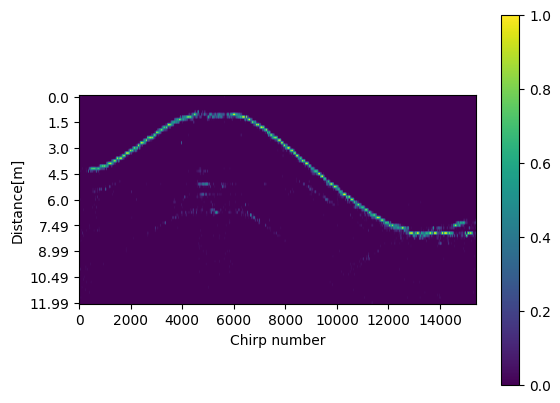

In [36]:
from pathlib import Path
from tqdm import tqdm
import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.ndimage import median_filter

from source.helper import to_dB, print_spectogram, gen_spectogram, diff_frames

BASE_DIR = Path("E:/radar-project/data")  # change to your project dir

loaded_file = h5py.File(BASE_DIR / 'complete_dataset.h5', 'r')

sample_file = loaded_file['2023_03_21']['chodzonko_1os_4-1-8m_bartek']
sample_file = sample_file[:, 0, 0, :]
normal_spect, y = gen_spectogram(sample_file)
normal_spect = to_dB(normal_spect)
frames_diff = diff_frames(sample_file, 1)
diff_spect, y = gen_spectogram(frames_diff)
diff_spectdb = to_dB(diff_spect)
smoothed_array = median_filter(diff_spectdb, size=(1, 500), mode='constant')
tresholded = np.zeros_like(smoothed_array)
max_indices = np.argmax(diff_spectdb, axis=0)
tresholded[max_indices, np.arange(diff_spectdb.shape[1])] = 1
print_spectogram(tresholded, y, depth_limit=12)

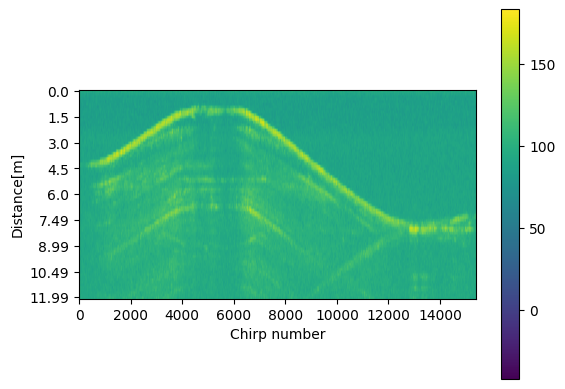

In [37]:
print_spectogram(diff_spectdb, y, depth_limit=12)

In [20]:
# # Create a Kalman filter with state space dimension of 256 and observation dimension of 256
# kf = KalmanFilter(dim_x=90, dim_z=90)
#
# # Define the state transition matrix, assuming a constant velocity model
# dt = 1.0  # time step
# kf.F = dt * np.eye(90, k=1)  # state transition matrix
# kf.Q = np.eye(90) * 10e-1  # process noise covariance matrix
#
# # Define the observation matrix
# kf.H = np.eye(90)
#
# # Define the measurement noise covariance matrix
# kf.R = np.eye(90) * 10e-1
#
# filtered_data = np.zeros((90, 15394))
#
# input_data = diff_spectdb[:90, :]
# # iterate over each time step
# state_estimate = np.zeros((90, 1))
# P = np.eye(90)*1
#
# for t in tqdm(range(15394)):
# # Initialize the state estimate and error covariance matrix
#     # Define the measurement as the current column of the data array
#     measurement = input_data[:, t].reshape(-1, 1)
#
#     # Predict the state estimate and error covariance matrix using the state transition matrix and process noise covariance matrix
#     kf.predict(state_estimate, P)
#
#     # Update the state estimate and error covariance matrix using the measurement, observation matrix, and measurement noise covariance matrix
#     kf.update(measurement)
#
#     filtered_data[:, t] = kf.x.reshape(-1)

In [21]:
# print_spectogram(filtered_data, y, depth_limit=12)

In [22]:
# print_spectogram(diff_spectdb, y, depth_limit=12)

In [38]:
# sample preparation
max_indices = np.argmax(diff_spectdb[:90, 1000:-1000], axis=0)[::-1]
input_data = max_indices[:,np.newaxis]

In [52]:
kf = KalmanFilter(dim_x=2, dim_z=1)

# Define the state transition matrix
dt = 1.0  # time step
kf.F = np.array([[1, dt], [0, 1]])

# Define the measurement function matrix
kf.H = np.array([[1, 0]])

# Define the process noise covariance matrix
q = 10e-20  # process noise
kf.Q = np.array([[q * dt ** 3 / 3, q * dt ** 2 / 2],
                 [q * dt ** 2 / 2, q * dt]])

# Define the measurement noise covariance matrix
r = 10e-5  # measurement noise
kf.R = np.array([[r]])

# Define the initial state and covariance matrix
x0 = np.array([max_indices[0], 0])  # initial state (position, velocity)
p0 = np.eye(2)  # initial covariance matrix

# Initialize the filter with the initial state and covariance matrix
kf.x = x0
kf.P = p0

positions = np.zeros((max_indices.shape[0], 1))

for t in tqdm(range(max_indices.shape[0])):
# Initialize the state estimate and error covariance matrix
    # Define the measurement as the current column of the data array
    current_var = np.var(max_indices[t-10:t+10])
    # print(t, current_var)
    if current_var > 100:
        q = 10e-25  # process noise
        kf.Q = np.array([[q * dt ** 3 / 3, q * dt ** 2 / 2],
                         [q * dt ** 2 / 2, q * dt]])
        r = 10e+5  # measurement noise
        kf.R = np.array([[r]])
    else:
        q = 10e-15  # process noise
        kf.Q = np.array([[q * dt ** 3 / 3, q * dt ** 2 / 2],
                         [q * dt ** 2 / 2, q * dt]])

        r = 10e-2  # measurement noise
        kf.R = np.array([[r]])

    z = np.array([input_data[t]])  # measurement at time i
    kf.predict()
    kf.update(z)
    positions[t] = kf.x[0]

100%|██████████| 13394/13394 [00:01<00:00, 9301.40it/s]


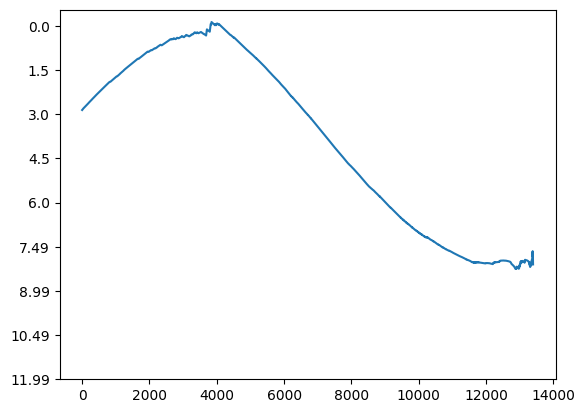

In [55]:
plt.plot(np.flip(np.where(positions < 90, positions, 90) , axis=(0, 1)))
plt.yticks(np.arange(start=0, stop=81, step=10), y[:81:10])
plt.gca().invert_yaxis()
plt.show()

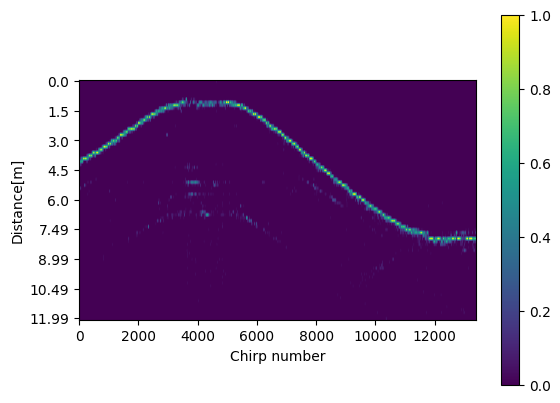

In [56]:
print_spectogram(tresholded[:, 1000:-1000], y, depth_limit=12)

In [57]:
flipped = np.flip(positions, axis=0)

In [58]:
flipped.shape

(13394, 1)

In [59]:
max_indices

array([54, 54, 54, ..., 27, 27, 27], dtype=int64)

In [60]:
normal_spect.shape

(256, 15395)

In [67]:
modified_normal_spect = diff_spectdb[:90, 1000:-1000]
cut = np.zeros_like(modified_normal_spect)
window_size = 2
for idx, column in enumerate(flipped):

    window_up_limit = int(column[0]) - window_size
    window_down_limit = int(column[0]) + window_size

    if window_up_limit < 0: window_up_limit = 0
    if window_down_limit > 90: window_down_limit = 90

    cut[window_up_limit:window_down_limit, idx] = modified_normal_spect[window_up_limit:window_down_limit, idx]

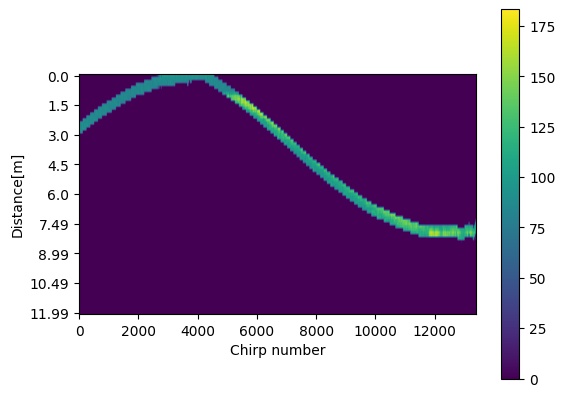

In [68]:
print_spectogram(cut, y, depth_limit=12)

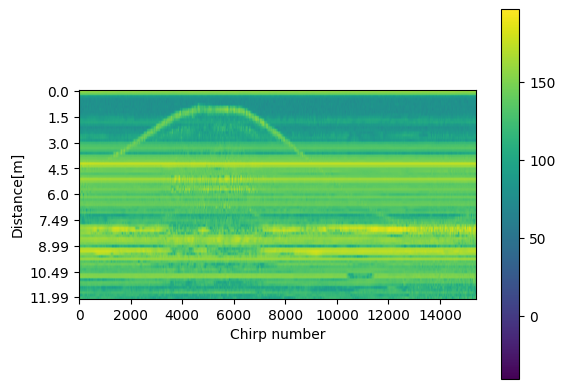

In [48]:
print_spectogram(normal_spect, y, depth_limit=12)